# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Изучение данных

In [1]:
import pandas as pd
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t', decimal='.')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


В предоставленной таблице насчитывается 23699 строк, при этом столбцы были изначально слипшимися. Разделили их с помощью параметра sep. Изучив общую информацию видим, что во многих столбцах сущетсвуют пропущенные значения.

### Шаг 2. Предобработка данных

In [2]:
for i in ['balcony','parks_around3000','ponds_around3000', 'kitchen_area']:    
    df[i] = df[i].fillna(0) 

df['is_apartment'] = df['is_apartment'].fillna(0)

df['living_area'] = df['living_area'].fillna(df['total_area']-df['kitchen_area'])

df['locality_name'] = df['locality_name'].fillna('Другой')

for i in ['days_exposition', 'ceiling_height', 'floors_total']:    
    df[i] = df[i].fillna(df[i].median()) 
df.query('floors_total<floor')['floors_total'] = df['floor']    

for i in [ 'airports_nearest', 'cityCenters_nearest', 'parks_nearest','ponds_nearest']:
    df[i] = df[i].fillna(df[i].max())           

for i in [
    'last_price','parks_around3000', 'ponds_around3000', 'days_exposition','floors_total',
    'airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'ponds_nearest'
]:    
    df[i] = df[i].astype('int') 
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df['is_apartment'] = df['is_apartment'].astype('bool') 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null int64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null int64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null float64
locality_name           23699 non-null object
airports_nearest        23699 non-null int64
cityCenters_nearest     23699 non-null int64
parks_around3000        23699 non-null int64
parks_nearest           23699 non-null int64
ponds_around3000   

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


В столбцах ['balcony','parks_around3000','ponds_around3000', 'kitchen_area'] значения пропущенны, скорее всего, из-за их 
отсутствия. Заменияем нулем.
Отсутствующее значение 'is_apartment' заменили нулем, т.к. скорее всего если не указано, что помещение является апартаментами,
оно не входит в эту категорию. 
Недостающие значения жилой площади вычислили как 'вся площадь' минус 'площадь кухни'.
Так как установить точно, в каком городе находится недвижимость, заполним пропущенные значения 'locality_name' на 'Другой'.
Пропущенные значения количественных переменных заменили медианными значениями.
Если количество этажей получилось больше, чем этаж, на котором расположена квартира, заменили количество этажей на этаж
квартиры.
Скорее всего значения в столбцах ['airports_nearest', 'cityCenters_nearest', 'parks_nearest','ponds_nearest'] не заполнены, 
так как данных объектов в близости от квартир не находится. Заменили их на максимально удаленное значение, встречающееся в 
датасете.

Изменили тип  числовых значений на  целочисленный (здесь нет дробей, которые нас бы интересовали), формат даты размещенияобъявления изменили на datetime, а столбца 'is_apartment' на булевый тип.

### Шаг 3. Расчет и добавление в таблицу новых значений

In [3]:
df['price_for_meter'] = (df['last_price']/df['total_area']).astype('int')
#Добавили расчет цены за метр, округленный до целого значения.

df['weekday_month_year'] = (
    df['first_day_exposition'].dt.weekday.astype('str') + '-' 
    + df['first_day_exposition'].dt.month.astype('str') + '-' 
    + df['first_day_exposition'].dt.year.astype('str')
)
#Добавили столбец с днем недели, месяцем и годом размещения объявления.

df['floor_new']= (
    df['floor'].where(df['floor'] != 1, 'первый')
    .where(df['floor'] !=df['floors_total'], 'пoследний')
    .where((df['floor'] == 1)|(df['floor'] ==df['floors_total']), 'другой')       
)
#df['floor_new'] определяет является этаж квартиры первым, последним или другим.

df['part_of_living_area'] = df['living_area']/df['total_area']
#df['part_of_living_area'] показывает соотношение жилой площади к общей

df['part_of_kitchen_area'] = (df['total_area']-df['living_area'])/df['total_area']
#df['part_of_kitchen_area'] показывает соотношение площади кухни к общей.

df.head(15)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_meter,weekday_month_year,floor_new,part_of_living_area,part_of_kitchen_area
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.00,8,False,...,1,482,2,755,95,120370,3-3-2019,другой,0.472222,0.527778
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.60,1,False,...,0,3190,0,1344,81,82920,1-12-2018,первый,0.460396,0.539604
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.30,4,False,...,1,90,2,574,558,92785,3-8-2015,другой,0.612500,0.387500
3,0,64900000,159.00,2015-07-24,3,2.65,14,159.00,9,False,...,2,84,3,234,424,408176,4-7-2015,другой,1.000000,0.000000
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,2,112,1,48,121,100000,1-6-2018,другой,0.320000,0.680000
5,10,2890000,30.40,2018-09-10,1,2.65,12,14.40,5,False,...,0,3190,0,1344,55,95065,0-9-2018,другой,0.473684,0.526316
6,6,3700000,37.30,2017-11-02,1,2.65,26,10.60,6,False,...,0,3190,0,1344,155,99195,3-11-2017,другой,0.284182,0.715818
7,5,7915000,71.60,2019-04-18,2,2.65,24,52.70,22,False,...,0,3190,0,1344,95,110544,3-4-2019,другой,0.736034,0.263966
8,20,2900000,33.16,2018-05-23,1,2.65,27,15.43,26,False,...,0,3190,0,1344,189,87454,2-5-2018,другой,0.465320,0.534680
9,18,5400000,61.00,2017-02-26,3,2.50,9,43.60,7,False,...,0,3190,0,1344,289,88524,6-2-2017,другой,0.714754,0.285246


### Шаг 4. Исследовательский анализ данных:

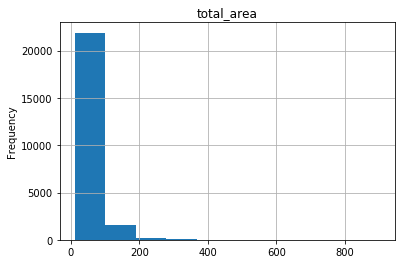

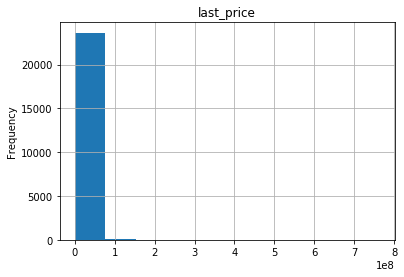

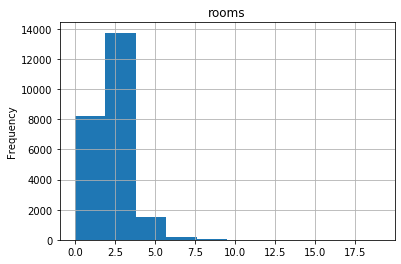

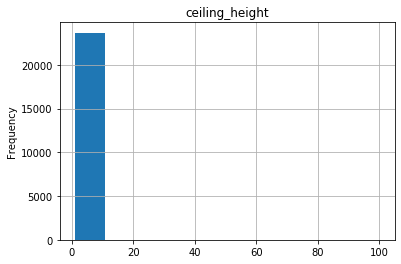

-----------------------------------------------------


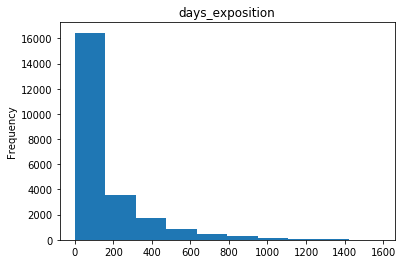

Среднее время продажи квартиры 169 дней
Обычно продажа занимает 95 дней (медиана)
Продажа прошла быстро, если заняла меньше 45 дней
Продажа проходит долго, если занимает больше 199 дней


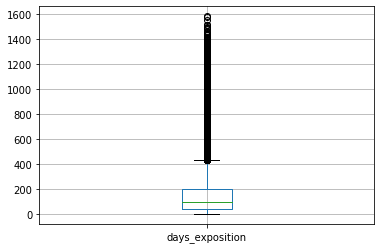

-----------------------------------------------------


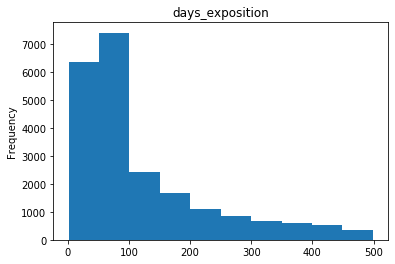

-----------------------------------------------------
  значение_1           значение_2  корреляция
0      price      price_for_meter    0.736499
1      price                rooms    0.363343
2      price  cityCenters_nearest   -0.228347
3      price            floor_new    0.040915
4      price              weekday    0.001550
5      price                month    0.002779
6      price                 year   -0.043089
-----------------------------------------------------
                   price_for_meter
locality_name                     
Санкт-Петербург              15721
посёлок Мурино                 522
посёлок Шушары                 440
Всеволожск                     398
Пушкин                         369
Колпино                        338
посёлок Парголово              327
Гатчина                        307
деревня Кудрово                299
Выборг                         237
-----------------------------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


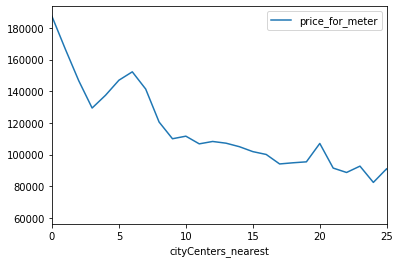

-----------------------------------------------------
   характеристика  в санкт-петербурге  в центре
0      total_area                  64        97
1      last_price             8062507  16022565
2           rooms                   2         3
3  ceiling_height                   2         3

rooms 0.2444983353235613
floor 0.22301232520228703
cityCenters_nearest -0.08927052747118913


In [8]:
import matplotlib.pyplot as plt

for i in ['total_area', 'last_price', 'rooms', 'ceiling_height']:
    df[i].plot(title=i, kind='hist', grid=True)
    plt.show() 
print('-----------------------------------------------------')

df['days_exposition'].plot(title='days_exposition', kind='hist')
plt.show()

import numpy as np
print('Среднее время продажи квартиры',int(df['days_exposition'].mean()),'дней')
print('Обычно продажа занимает',int(df['days_exposition'].median()),'дней (медиана)')
print('Продажа прошла быстро, если заняла меньше',int(np.percentile(df['days_exposition'], 25)),'дней')
print('Продажа проходит долго, если занимает больше',int(np.percentile(df['days_exposition'], 75)),'дней')
df.boxplot(column='days_exposition')
plt.show()
print('-----------------------------------------------------')

df.query('days_exposition < 500')['days_exposition'].plot(title='days_exposition', kind='hist')
plt.show()
print('-----------------------------------------------------')

df['floor_new']= (
    df['floor'].where(df['floor'] != 1, 1)
    .where(df['floor'] !=df['floors_total'], 2)
    .where((df['floor'] == 1)|(df['floor'] ==df['floors_total']), 3)       
)

columns = ['значение_1', 'значение_2', 'корреляция']
data = [
    ['price', 'price_for_meter', df['last_price'].corr(df['price_for_meter'])],
    ['price', 'rooms', df['last_price'].corr(df['rooms'])],
    ['price', 'cityCenters_nearest', df['last_price'].corr(df['cityCenters_nearest'])],
    ['price', 'floor_new', df['last_price'].corr(df['floor_new'])],
    ['price', 'weekday', df['last_price'].corr(df['first_day_exposition'].dt.weekday)],
    ['price', 'month', df['last_price'].corr(df['first_day_exposition'].dt.month)],
    ['price', 'year', df['last_price'].corr(df['first_day_exposition'].dt.year)]
]

correlation = pd.DataFrame(data=data, columns=columns)
print(correlation)
print('-----------------------------------------------------')

popular_cities_villages = df.groupby('locality_name').count().sort_values(by='last_price', ascending=False).head(10)
cities_villages = popular_cities_villages.pivot_table(index='locality_name', values='price_for_meter', aggfunc='mean')
print(cities_villages.sort_values(by='price_for_meter', ascending=False))
print('-----------------------------------------------------')
      
flats_in_spb = df.query('locality_name =="Санкт-Петербург"')
flats_in_spb['cityCenters_nearest'] = flats_in_spb['cityCenters_nearest'].fillna(flats_in_spb['cityCenters_nearest'].median())
flats_in_spb['cityCenters_nearest']=(flats_in_spb['cityCenters_nearest']/1000).astype('int')
pivot_table_spb = flats_in_spb.pivot_table(index='cityCenters_nearest', values='price_for_meter', aggfunc='mean')
#print(pivot_table_spb)

pivot_table_spb.plot(xlim=(0,25)) 
plt.show()
print('-----------------------------------------------------')

flats_in_the_center = flats_in_spb.query('cityCenters_nearest <=3')
columns2=['характеристика','в санкт-петербурге','в центре']
data2=[]
for i in ['total_area', 'last_price', 'rooms', 'ceiling_height']:
    data2.append([i, int(flats_in_spb[i].mean()), int(flats_in_the_center[i].mean())])

    compare_table= pd.DataFrame(columns=columns2, data=data2)    
print(compare_table)
print()

for i in ['rooms','floor','cityCenters_nearest']:   
    print(i, flats_in_the_center[i].corr(flats_in_the_center['last_price']))

Построили гистограммы для характеристик 'total_area', 'last_price', 'rooms', 'ceiling_height'. Подписали графики с помощью 
параметра 'title'.

Изучили время продажи квартиры. Будем считать, что продажа прошла быстро, если она заняла меньше 1 квартиля времени, 
а долго, если она заняла больше 3 квартилей.

На диаграмме размаха (в предыдущем шаге) увидели, что выбросами можно считать значения превышающие примерно 420. 
Избавились от выбросов, построили гистограмму по оставшимся значениям.
По ней видно, что в абсолютном большинстве случаев, продажа приходится на первые 100 дней. А дальше, число событий за
единицу времени уменьшается, что соответствует распределению Пуассона.

Изучили корреляцию цены квартиры от таких характеристик, как цена за квадратный метр, количество комнат, расстояние
от центра, этаж(первый/последний/другой), день недели, месяц, год размещения объявления.
Значимая корреляция обнаружилась только с ценой за квадратный метр (0.736499).

Среди 10 населенных пунктов с самым большим числом объявлений самая большая цена за квадратный метр оказалась в
Санкт-Петербурге(15721), а самая низкая в Выборге(237).

Построили график зависимости цены за квадратный метр в Санкт-Петербурге от удаленности от центра. В графике есть границы, где
он сильно меняется - 3 км. Будем ее считать границей центра города.

Выделили сегмент квартир в центре в таблицу flats_in_the_center. 
Сравнили значения 'total_area', 'last_price', 'rooms', 'ceiling_height' для всего города целиком и для центра.
Все параметры в центре оказались выше аналогичных по городу.
Провели влияние таких параметров как 'rooms','floor','cityCenters_nearest' на цену квартир в городе. Корреляция оказалась несущественной (|<0.3|).

### Шаг 5. Общий вывод

Изучив данные объявлений о продаже квартир выяснили:
1. Имеется большое количество пропущенных значений. В таких столбцах, как балкон или парки поблизости, значения пропущены скорее всего по причине отсутствия этих характеристик (заменили нулем), такие значения как высота потолков или общее количество этажей можно заменить медианным значением (учитывая, что число этажей должно быть не меньше, чем этаж, на котором располагается квартира). 
2. Тип данных количественных переменных заменили на 'int', а столбца с датой размещения объявления на 'datetime'. Столбец 'is apartment' привели к типу 'bool', так как его значения состоят только из 2 вариантов.
3. Добавили в таблицу: цену квадратного метра, день недели,месяц, год публикации объявления, этаж(первый, последний или другой), соотношение жилой площади к общей, а также площади кухни к общей.
4. Построили гистограммы по требуемым параметрам. 
5. Изучили время продажи квартиры. Выяснили, что среднее время является равным 169 дней, а медианное 95, т.к. существует много выбросов. Можно считать, что продажа прошла быстро, если заняла меньше 45 дней, а долго, если заняла больше 199 дней.
6. Рассмотрели корреляцию цены квартиры от различных параметров. Выяснили, что корреляция присутствует с ценой за метр (0.736499), а с остальными параметрами несущественна.
7. Построили сводную таблицу по 10 населенным пунктам с наибольшим числом объявлений. Среди них выше всего цена за квадратный метр оказалась в Санкт-Петербурге - 15721, а ниже всего в Выборге -237.
8. На графике зависимости цены за квадратный метр от расстояния до центра в Санкт-Петербурге наблюдаем границу, где график сильно меняется - 3 км. Предполагем, что это граница центра города.
9. Выделили сегмент квартир в центре отдельно и изучили соотношение различных параметров для города в целом и для центра.  Такие характеристики как общая площадь, цена, количество комнат и высота потолков в центре оказались выше аналогичных по городу (например средняя площадь в центре 97 м2, а по городу 64 м2).
10. Так же проверили, как на цену квартир в центре влияют такие параметры как количество комнат, этаж и удаленность от центра. Корреляции оказалось несущественной.